In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 


#CT Radon transform forward model and denoising functions
from skimage.transform import radon, resize, iradon
from skimage.data import shepp_logan_phantom
from skimage.restoration import denoise_tv_chambolle
import bm3d 

#Plug and Pla
import pnp_mace as pnpm
from dotmap import DotMap

# Test image
phantom = shepp_logan_phantom()
num_scans = 180
angles = np.linspace(0., 360, num_scans, endpoint=False)
phantom_resized = resize(phantom, (200, 200), mode='reflect')

#Forward model (Radon transform) and FBP inversion
def A(x):
    angles = np.linspace(0., 360, num_scans, endpoint=False)
    return radon(x, theta=angles, circle=True)

def AT(x):
    angles = np.linspace(0., 360, num_scans, endpoint=False)
    return iradon(x, theta=angles, circle=True)

#Denoiser for the prior - can use any
def denoiser(x, params):
    denoised_x = denoise_tv_chambolle(x, weight=params.noise_std)
    return denoised_x




In [2]:
#display results function

def display_images(image_list, image_titles, ground_truth):
    titles = []
    for img, title in zip(image_list, image_titles):
        
        #cur_min = np.round(np.amin(img), 1)
        #cur_max = np.round(np.amax(img), 1)
        #bounds = '{} to {}'.format(str(cur_min), str(cur_max))
        psnr = PSNR(ground_truth, img)
        titles.append(title + f' PSNR: {psnr:.2f} dB \n')
        

        #nrmse = pnpm.nrmse(img, ground_truth)
        #titles.append(title + ' [NRMSE: ' + str(nrmse) + ']')

    for img, title in zip(image_list, titles):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 5))
        

        ax.imshow(img, cmap='gray')
        #pnpm.display_image(img, fig=fig, ax=ax, cmap='gray')

        plt.suptitle(title)
        plt.tight_layout()
        fig.show()




# Base PnP-ADMM with usual denoisers (Discretised Radon transform)

In [3]:
#Discretised version with A
n = 84

circle = False
n_angles = 60
theta = np.linspace(0., 180.,n_angles, endpoint=False)
sigma = 100e-1
size = (radon(np.zeros((n,n)), theta=theta, circle = circle)).shape
M = size[0]*size[1]
A = np.zeros((M, n**2))
for i in range(n**2):
    e = np.zeros((n**2,))
    e[i]=1
    e = np.reshape(e,(n,n))
    sinogram = radon(e, theta=theta, circle = circle)
    A[:,i] = np.reshape(sinogram[:], (M,))

# Load the Shepp-Logan phantom
phantom = resize(shepp_logan_phantom(), (n,n))



In [4]:
max_pixel = np.amax(phantom)
max_pixel

#Peak signal to noise ratio
def PSNR(original, img, max_value = max_pixel): 
    mse = np.mean((np.array(original, dtype=np.float32) - np.array(img, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    psnr = 20 * np.log10(max_value / (np.sqrt(mse)))
    return psnr



Text(0.5, 1.0, 'Ground truth (Shepp-Logan Phantom)')

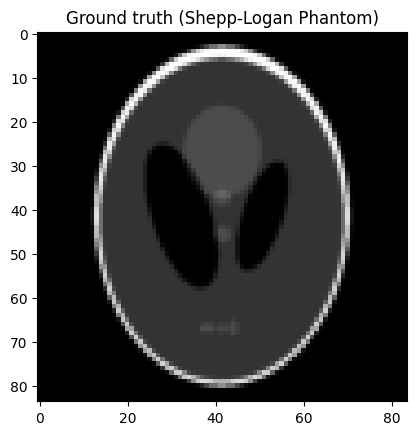

In [5]:
#ground truth
x = phantom.reshape(-1)

plt.imshow(phantom, cmap='gray')
plt.title("Ground truth (Shepp-Logan Phantom)")

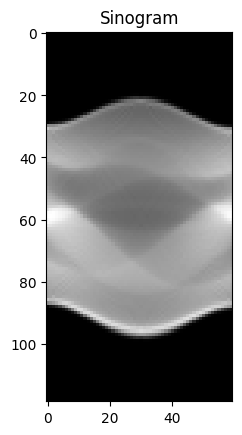

In [6]:
#b
clean_sinogram_flattened = A@x.flatten()
b = clean_sinogram_flattened + np.random.normal(0,1,7140)

y = np.reshape(A@x, (int(np.ceil(n*np.sqrt(2))), n_angles))
plt.title("Sinogram")
plt.imshow(y, cmap='gray')

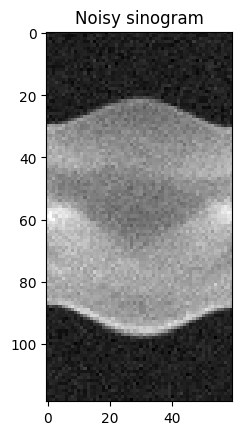

In [7]:
#noisy sinogram
plt.title("Noisy sinogram")
s = np.reshape(b, (int(np.ceil(n*np.sqrt(2))), n_angles))
plt.imshow(s, cmap='gray')

Text(0.5, 1.0, 'FBP reconstruction')

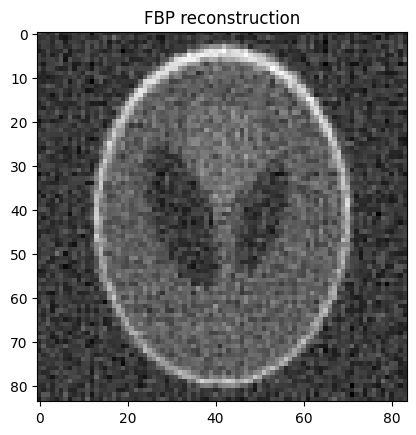

In [8]:
reconstruction_fbp = iradon(s, theta=theta, filter_name='ramp', circle=False)
plt.imshow(reconstruction_fbp, cmap='gray')
plt.title('FBP reconstruction')

## Denoisers (TV, BM3D, K-SVD)

In [9]:
from bm3d import bm3d
from sklearn.feature_extraction import image

def ksvd_denoise(x):
    patches = image.extract_patches_2d(x, (8,8))
    


In [10]:
from tqdm import tqdm

def pnp_admm(A, b, x_ground_truth, denoiser, l = 20, niter = 20):
    """
    Alternating directions method of multiplers with different denoisers to use  
    """ 

    def apply_denoiser(x, method):
        """
        Denoiser options for the u step (replacing the proximal operator)
        """
        if method == 'tv':
            return denoise_tv_chambolle(x, weight = 0.3)
        elif method == 'bm3d':
            return bm3d(x, sigma_psd = 5.9)
        elif method == 'proximal':
            return np.sign(x)*np.maximum(0, x)
        

    def nrmse(x, x_ground_truth):
        """
        Normalised root mean square error between final prediction and ground truth image
        """
        return np.linalg.norm(x - x_ground_truth)/np.linalg.norm(x_ground_truth)

    
    #dimensions
    n = int(np.sqrt(A.shape[1]))
    #defining the 3 variables for use
    x = np.zeros_like(x_ground_truth)
    u = np.zeros_like(x_ground_truth)
    v = np.zeros_like(x_ground_truth)
    metric_list = []

    #PnP ADMM iteration performed on the 3 variables
    for i in tqdm(range(niter), desc = 'PnP ADMM iterations'):
        
        #FBP inversion
        measurement = np.reshape(b, (int(np.ceil(n*np.sqrt(2))), n_angles))
        correction = np.reshape(A@(l*(u - v)), (int(np.ceil(n*np.sqrt(2))), n_angles))
        fbp = measurement + correction
        x = iradon(fbp, theta= theta, filter_name='ramp', circle=False)
        #x = np.linalg.solve(A.T @ A + rho * np.eye(A.shape[1]), A.T @ b + rho * (u - v))

        # reshaping u and v for the denoiser (1D to 2D)
        u = u.reshape((n, n))
        v = v.reshape((n, n))
        u = apply_denoiser(x + v, denoiser)
        v += x - u

        #flattening u and v for the next iteration when applying FBP (2D to 1D)
        u = u.flatten()
        v = v.flatten()


        current_psnr = PSNR(x_ground_truth, x.flatten())
        #print("current PSNR:", current_psnr)

        #current_nrmse = nrmse(x.flatten(), x_ground_truth)
        metric_list.append(current_psnr)

        
    print("Final PSNR:", current_psnr)

    return x, metric_list



In [11]:
result_tv, metrics_tv = pnp_admm(A, b, x, 'tv', niter = 50)
result_bm3d, metrics_bm3d = pnp_admm(A, b, x, 'bm3d', niter = 50)

PnP ADMM iterations: 100%|██████████| 50/50 [00:01<00:00, 26.43it/s]


Final PSNR: 22.761742681709155


PnP ADMM iterations: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]

Final PSNR: 20.23536838366139


In [12]:
result_proximal, metrics_prox = pnp_admm(A, b, x, 'proximal', niter = 50)

PnP ADMM iterations: 100%|██████████| 50/50 [00:01<00:00, 34.99it/s]

Final PSNR: 21.213697414287076


C:\Users\as5057\AppData\Local\Temp\ipykernel_5872\2930828785.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


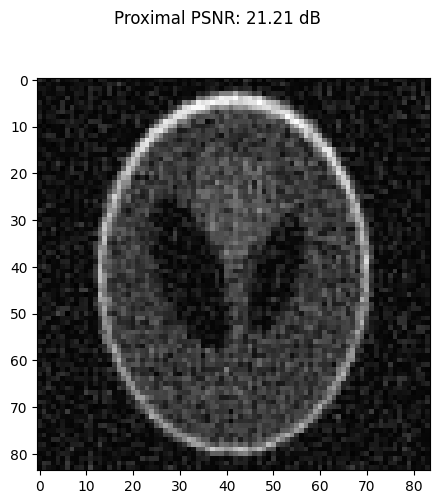

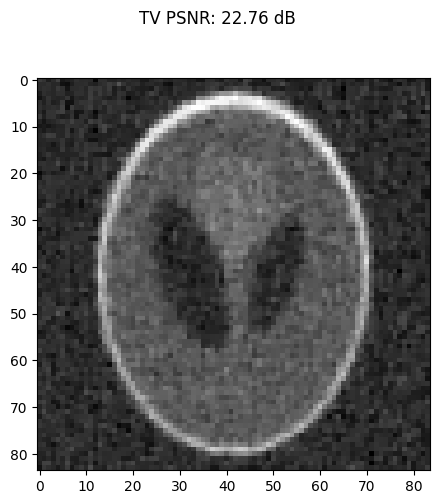

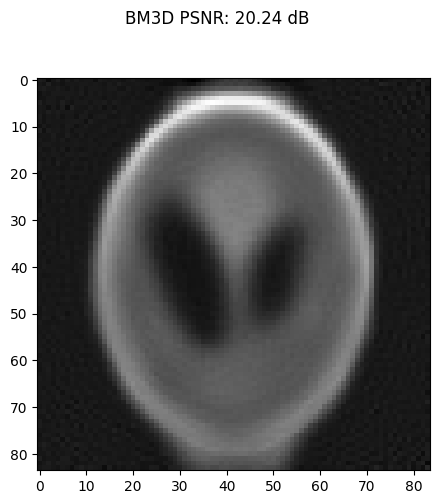

In [13]:
display_images([result_proximal ,result_tv, result_bm3d], ['Proximal','TV', 'BM3D'], phantom)

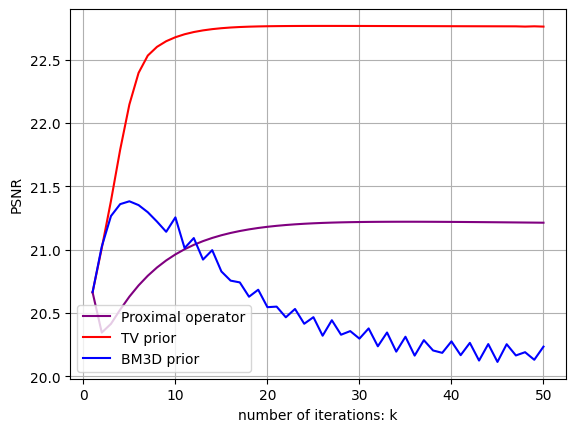

In [14]:
def comparison_plot(norm_res, method, ytitle='PSNR', color='k'):
    K = len(norm_res)

    plt.plot(range(1, len(norm_res) + 1),norm_res, color=color, label=method)
    k = np.arange(K)

    plt.ylabel(ytitle)
    plt.xlabel('number of iterations: k')
    plt.legend()
    plt.grid(True)

comparison_plot(metrics_prox, 'Proximal operator', color='purple')
comparison_plot(metrics_tv, 'TV prior', color='red')
comparison_plot(metrics_bm3d, 'BM3D prior', color='blue')

# Forward-backward splitting (FBS/PGD)
## PnP-ISTA and PnP-FISTA


In [15]:
#ISTA
def soft_thresh(x, l):
    return np.sign(x) * np.maximum(np.abs(x) - l, 0.)


def denoiser(x, l, method):
        """
        Denoiser options to replace the proximal step
        """
        L = np.linalg.norm(A) ** 2  # Lipschitz constant
        if method == 'tv':
            return denoise_tv_chambolle(x, weight = 0.3)
        elif method == 'bm3d':
            return bm3d(x, sigma_psd = 5.9)
        elif method == 'proximal':
            return soft_thresh(x, l / L)


def pnp_ista(A, b, x_truth, method, l, iters, tol = 1e-3):
    """
    
    PnP iterative shrinkage thrseholding algorithm (PnP-FISTA)
    """
    x = np.zeros(A.shape[1])
    #minimisations = []
    psnrs = []
    L = np.linalg.norm(A) ** 2  # Lipschitz constant
    for i in tqdm(range(iters), desc = 'PnP PGD iterations'):
        #gradient descent step
        grad_g = A.T @ (A @ x - b)
        x_descent = x - (grad_g/ L)

        #denoising step
        x = denoiser(x_descent, l, method)
        #x = soft_thresh(x_descent, l / L)


        #current_min = 0.5 * np.linalg.norm(A.dot(x) - b) ** 2 + l * np.linalg.norm(x, 1)
        #minimisations.append(current_min)
        #diff = np.linalg.norm(x - x_truth)/np.linalg.norm(x_truth)
        psnr = PSNR(x_truth, x)
        psnrs.append(psnr)
        if np.linalg.norm(grad_g) <= tol:  # Termination criterion
            print('Iteration {}: gradient norm {:.4e} is less than tolerance {}\n'.format(i, np.linalg.norm(grad_g), tol))
            break

    print("Final PSNR:", psnr)

    return x, psnrs


def pnp_fista(A, b, x_g, method, l, iters, tol = 1e-3):
    """
    PnP FISTA (accelerated PGD)
    """
    #ground = 0.5 * np.linalg.norm(A.dot(x_g) - b) ** 2 + l * np.linalg.norm(x_g, 1)
    x = np.zeros(A.shape[1])
    psnrs = []

    #Initialisation of parameters (step size and initial guesses)
    t = 1
    z = x.copy()
    L = np.linalg.norm(A) ** 2
    for i in tqdm(range(iters), desc = 'PnP FISTA iterations'):
        grad_g = A.T @ (A @ x - b)
        xold = x.copy()
        z = z + A.T.dot(b - A.dot(z)) / L
        x = denoiser(z, l, method)
        t0 = t
        t = (1. + np.sqrt(1. + 4. * t ** 2)) / 2.
        z = x + ((t0 - 1.) / t) * (x - xold)
        
        #diff = np.linalg.norm(x - x_g)/np.linalg.norm(x_g)
        psnr = PSNR(x_g, x)
        psnrs.append(psnr)
        if np.linalg.norm(grad_g) <= tol:  # Termination criterion
            print('Iteration {}: gradient norm {:.4e} is less than tolerance {}\n'.format(k, np.linalg.norm(grad_g), tol))
            break

        """
        if i == 1:
          Xone = x
        elif i == 250:
          X250 = x

        """

    print("Final PSNR:", psnr)
        
        


    return x, psnrs





def plot_and_estimate_convergence(norm_res, alpha, ytitle, color='k'):
    K = len(norm_res)
    method = "$\\lambda = $" + str(alpha)
    plt.semilogy(norm_res, color=color, label=method)
    k = np.arange(K)

    plt.ylabel(ytitle)
    plt.xlabel('number of iterations: k')
    plt.legend()
    plt.grid(True)





In [16]:
x_ground_truth = x

#x2, r2 = pnp_ista(A, b, x_ground_truth, 'tv', 0.1, 200)
#x_final, r3 = pnp_ista(A, b, x_ground_truth, 'bm3d', 0.1, 200)


In [17]:
xf, relative = pnp_ista(A, b, x_ground_truth, 'proximal', 20, 200)
x_f, r = pnp_fista(A, b, x_ground_truth, 'proximal', 20, 200)


PnP PGD iterations: 100%|██████████| 200/200 [00:11<00:00, 17.69it/s]


Final PSNR: 16.718154766756243


PnP FISTA iterations: 100%|██████████| 200/200 [00:19<00:00, 10.29it/s]

Final PSNR: 24.34449548461035


# FISTA and ISTA comparison with the proximal operator

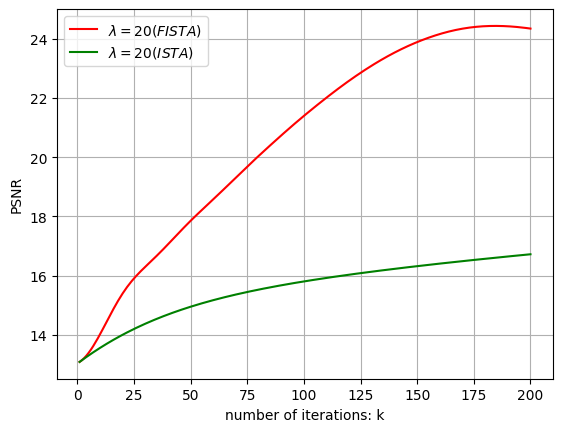

In [18]:
comparison_plot(r, "$\\lambda = 20 (FISTA)$",'PSNR', color='red')
comparison_plot(relative, "$\\lambda = 20 (ISTA)$",'PSNR', color='green')

In [19]:
from sklearn.model_selection import KFold

def grid_search_lambda_residual(A, b, x_g, l_range, denoiser, iters=100, cv=5):
    """     
    Grid search for the optimal lambda using cross-validation
    """
    kf = KFold(n_splits=cv)
    best_lambda = None
    best_score = float('inf')

    for l in l_range:
        scores = []
        for train_index, val_index in kf.split(A):
            A_train, A_val = A[train_index], A[val_index]
            b_train, b_val = b[train_index], b[val_index]

            x, _, _ = pnp_fista(A_train, b_train, x_g, denoiser, l, iters)
            val_error = np.linalg.norm(A_val.dot(x) - b_val) / np.linalg.norm(b_val)
            

            scores.append(val_error)

        mean_score = np.mean(scores)
        print(f'Lambda: {l:.4f}, Mean Validation Error: {mean_score:.4f}')
        if mean_score < best_score:
            best_score = mean_score
            best_lambda = l

    print(f'Best lambda: {best_lambda:.4f} with Mean Validation Error: {best_score:.4f}')
    return best_lambda


In [20]:

#Old setup
def grid_search_fista_relative(A, b, x_ground_truth, lambdas, denoiser, iters=200):
    """
    Grid search for best lambda erange for relative error
    """
    best_lambda = None
    best_relative_error = np.inf
    errors = []

    for l in lambdas:
        _, errors = pnp_fista(A, b, x_ground_truth, denoiser, l, iters)
        relative_error = errors[-1]
        errors.append(relative_error)
        print(f'Lambda: {l:.4f}, Relative Error: {relative_error:.4f}')
        if relative_error < best_relative_error:
            best_relative_error = relative_error
            best_lambda = l

    print(f'Best lambda: {best_lambda:.4f} with Mean Validation Error: {best_relative_error:.4f}')
    return best_lambda, errors



#PSNR grid search setup
def grid_search_fista_psnrs(A, b, x_ground_truth, lambdas, denoiser, iters=200):
    best_lambda = None
    best_psnr = 0
    psnrs = []

    for l in lambdas:
        _, psnrs = pnp_fista(A, b, x_ground_truth, denoiser, l, iters)
        psnr = psnrs[-1]
        psnrs.append(psnr)
        print(f'Lambda: {l:.4f}, PSNR: {psnr:.4f}')
        if psnr > best_psnr:
            best_psnr = psnr
            best_lambda = l

    print('Best lambda:', best_lambda, 'with PSNR:', round(best_psnr, 3))
    return best_lambda, psnrs


In [21]:
lambda_range = [10, 20, 30, 40, 100, 1000]
best_lambda, psnrs = grid_search_fista_psnrs(A, b, x_ground_truth, lambda_range, 'proximal')

PnP FISTA iterations: 100%|██████████| 200/200 [00:20<00:00,  9.58it/s]


Final PSNR: 24.190145176801394
Lambda: 10.0000, PSNR: 24.1901


PnP FISTA iterations: 100%|██████████| 200/200 [00:19<00:00, 10.20it/s]


Final PSNR: 24.34449548461035
Lambda: 20.0000, PSNR: 24.3445


PnP FISTA iterations: 100%|██████████| 200/200 [00:19<00:00, 10.10it/s]


Final PSNR: 24.336813127586087
Lambda: 30.0000, PSNR: 24.3368


PnP FISTA iterations: 100%|██████████| 200/200 [00:19<00:00, 10.13it/s]


Final PSNR: 24.294950723005527
Lambda: 40.0000, PSNR: 24.2950


PnP FISTA iterations: 100%|██████████| 200/200 [00:19<00:00, 10.34it/s]


Final PSNR: 23.62898000663444
Lambda: 100.0000, PSNR: 23.6290


PnP FISTA iterations: 100%|██████████| 200/200 [00:20<00:00,  9.71it/s]

Final PSNR: 13.02332432125331
Lambda: 1000.0000, PSNR: 13.0233
Best lambda: 20 with PSNR: 24.344


In [22]:
lamb = 20
iters = 200
x_prox, psnr_1 = pnp_ista(A, b, x_ground_truth, 'proximal', lamb, iters)
x_tv, psnr_2 = pnp_ista(A, b, x_ground_truth, 'tv', lamb, iters)
#x_bm3d, psnr_3 = pnp_fista(A, b, x_ground_truth, 'bm3d', lamb, iters)

PnP PGD iterations: 100%|██████████| 200/200 [00:12<00:00, 16.10it/s]


Final PSNR: 16.718154766756243


PnP PGD iterations: 100%|██████████| 200/200 [00:16<00:00, 12.08it/s]

Final PSNR: 14.745717964050728


C:\Users\as5057\AppData\Local\Temp\ipykernel_5872\2930828785.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


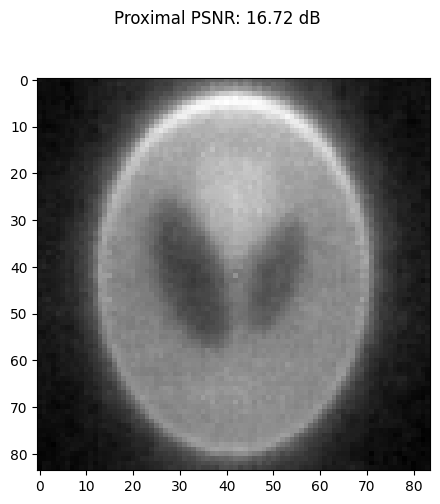

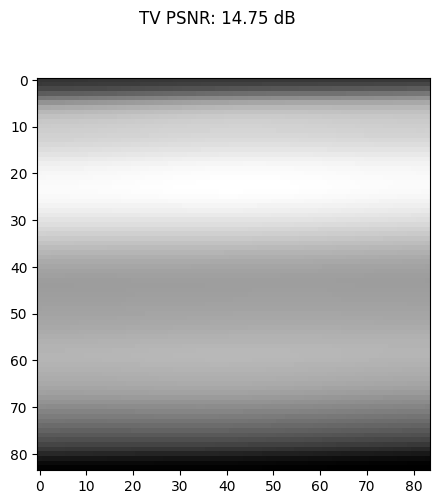

In [23]:
display_images([x_prox.reshape(n,n), x_tv.reshape(n,n)], ['Proximal','TV'], phantom)

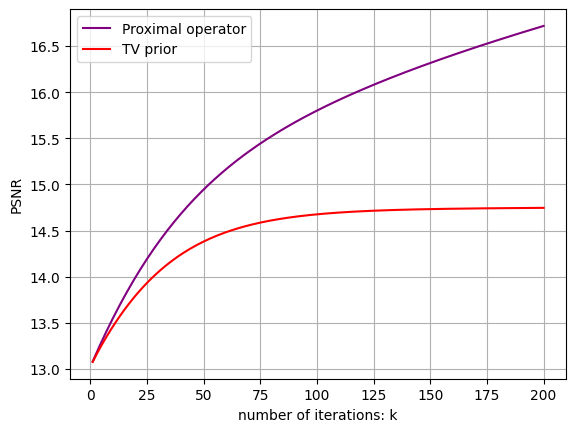

In [24]:
plt.clf()
comparison_plot(psnr_1, 'Proximal operator', color='purple')
comparison_plot(psnr_2, 'TV prior', color='red')
#comparison_plot(metrics_bm3d, 'BM3D prior', color='blue')